# BoomBikes - Multiple Linear Regression

### Problem statement:
BoomBikes wants to know the following
1. Predictors for the demand of shared bikes
2. How well these predictors describe the demand
3. Model the demand to understand the potential demands in new market

In [1]:
# Library import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')


#### Read and explore/understand the data

In [2]:
df = pd.read_csv("day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Data dictionary:

    - instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [3]:
df.shape

(730, 16)

730 data points with 16 variables, cnt is the target variable to be predicted

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


No null entries

From data dictionary, information about year, month and day is available either in direct or encoded form. Therefore column "dteday" can be droped directly

In [5]:
df.drop(labels=['dteday'],axis="columns",inplace=True)

In [6]:
df.shape

(730, 15)

In [7]:
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


Value range of the variables are within the boundaries provided in data dictionary. No implausible value

temp and atemp seems to be within the valid range

Humidity of ~97% possible

Duplicate entries in the instance to be checked

In [8]:
df["instant"].duplicated().sum()

0

No duplicate entries

##### Data visualization

<Figure size 720x720 with 0 Axes>

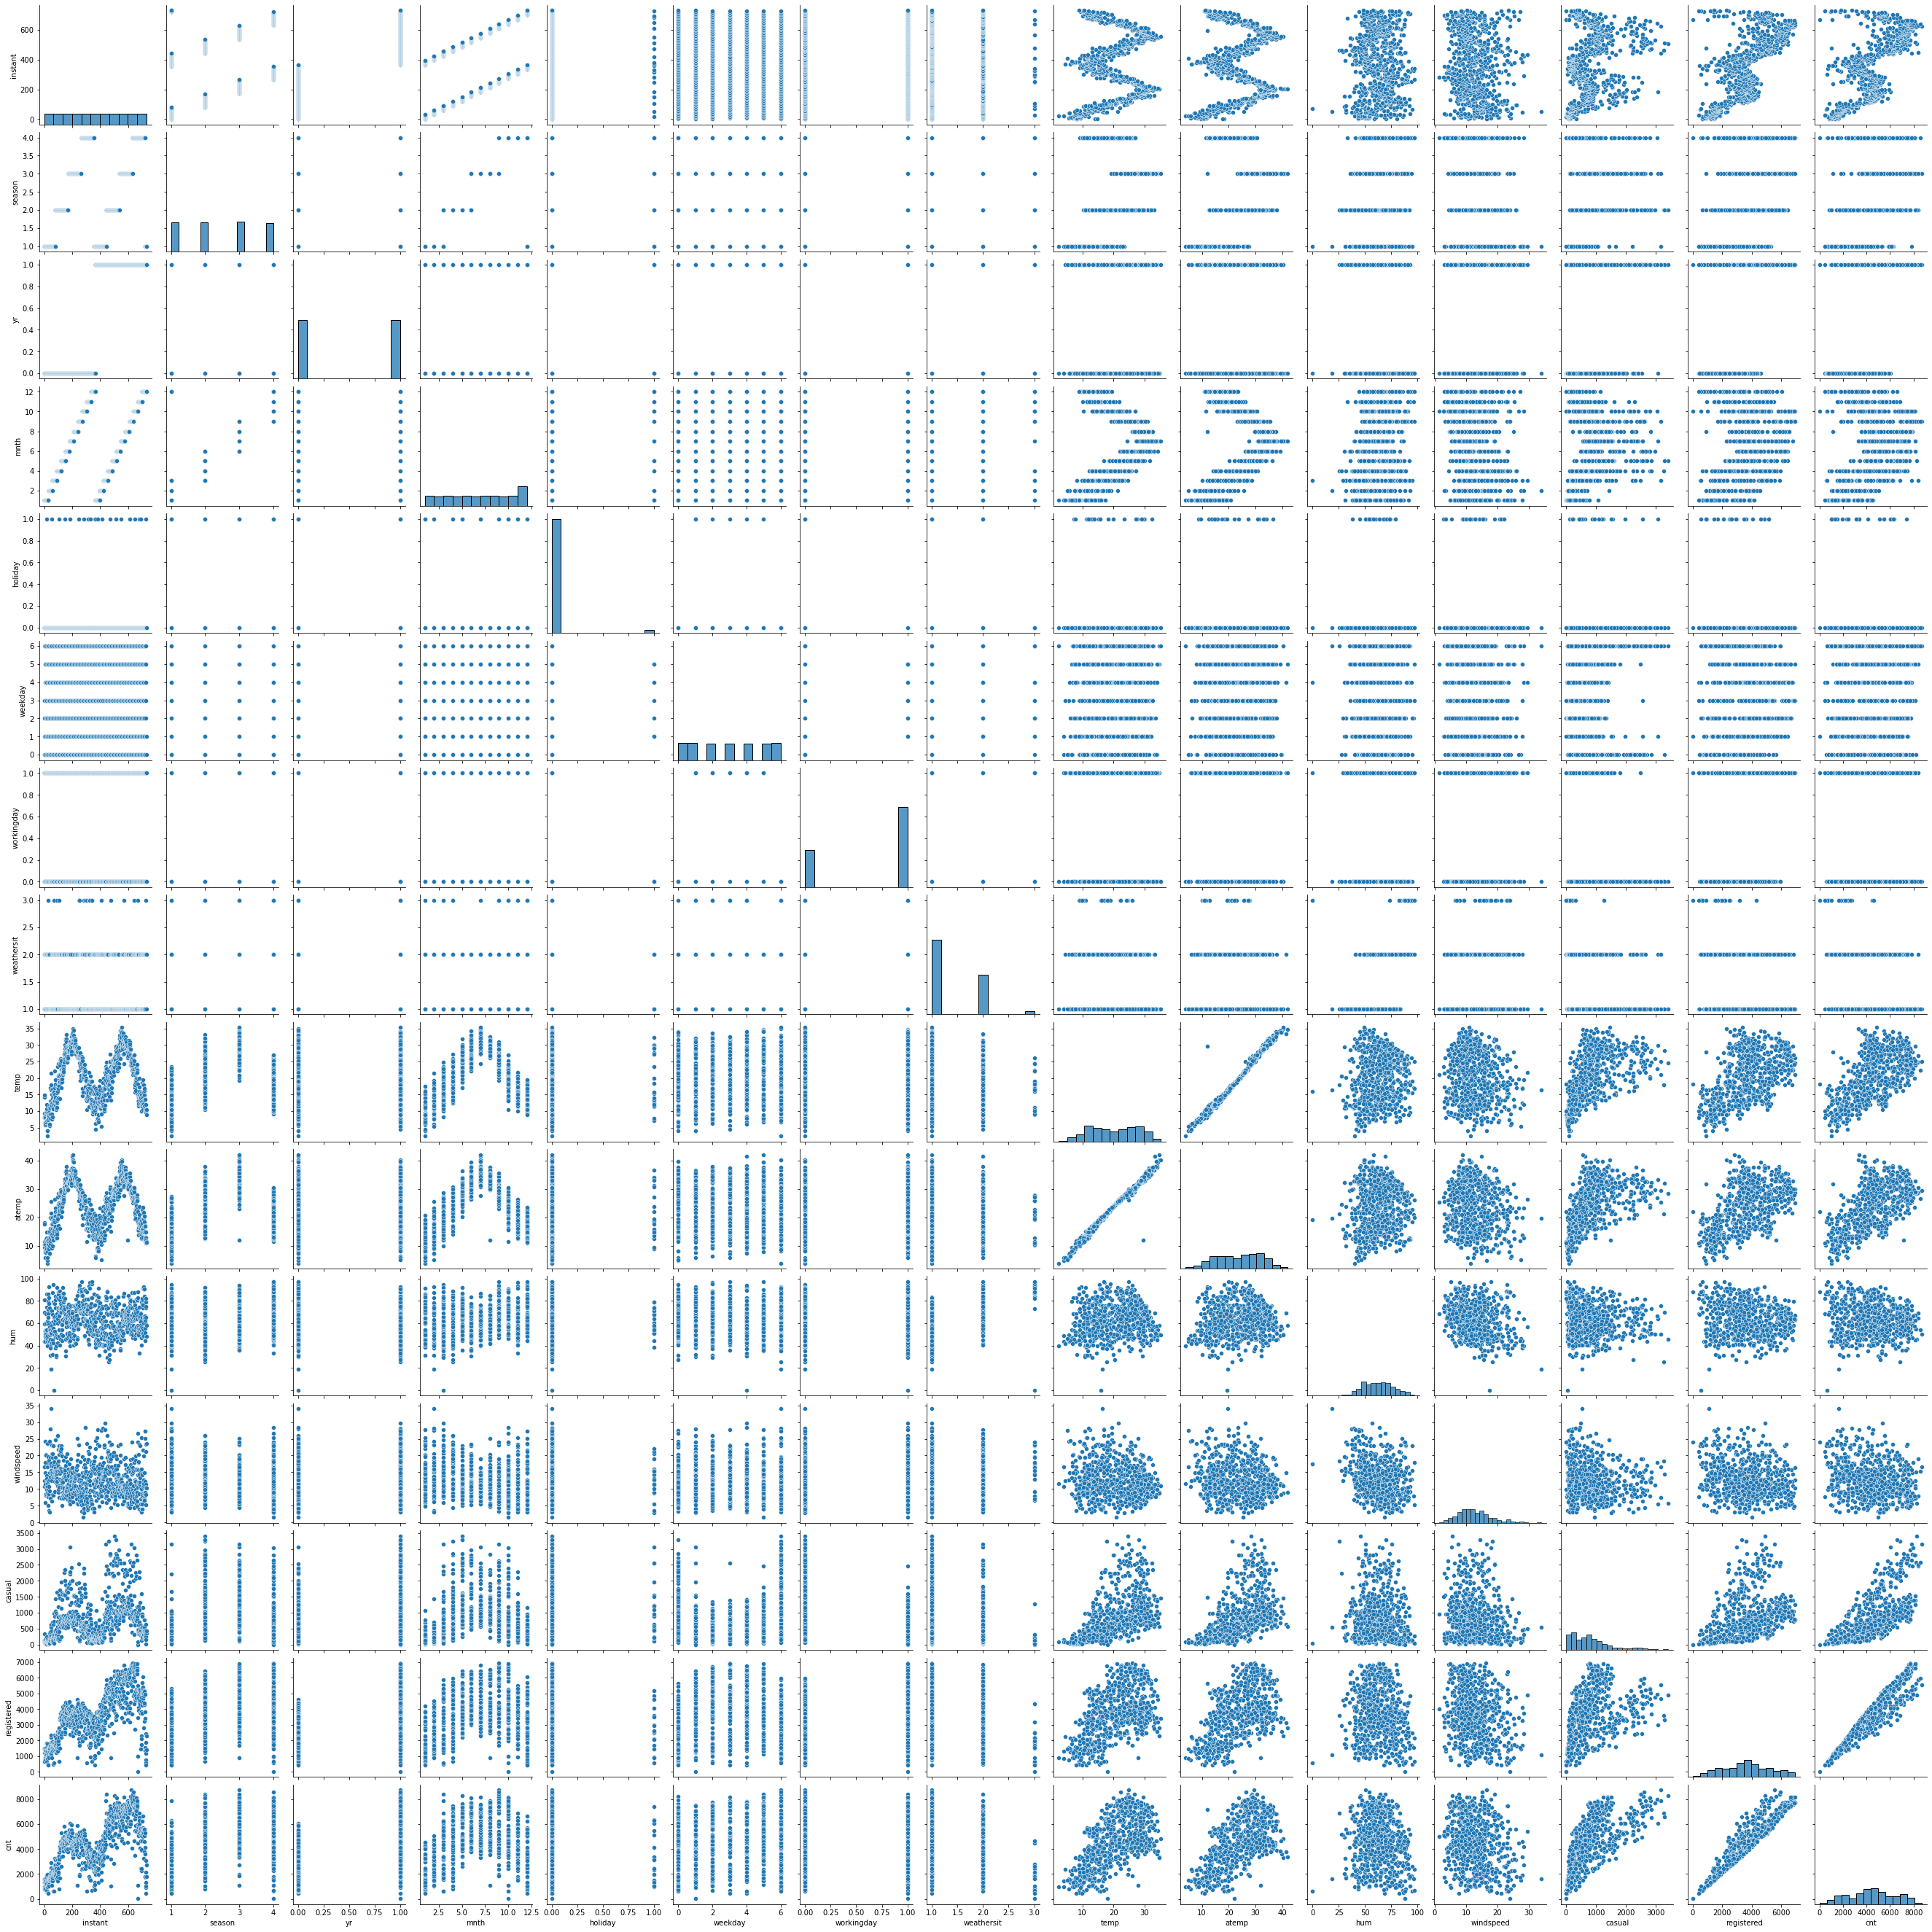

In [9]:
plt.figure(figsize=(10,10))
sns.pairplot(df)

- instant is for sure not a predictor. It is just a unique identified. This column can be droped
- There seem a linear relation between temp and cnt. atemp is expected to be highly cor-related with temp so similar relation with cnt
- casual and registered users are basically the different categories with in cnt. Therefore their relationship with cnt will not make any sense to be understood
- Data distribution of all the variables seem normal. Higher data points of december month are available in the dataset

<AxesSubplot:xlabel='weathersit', ylabel='cnt'>

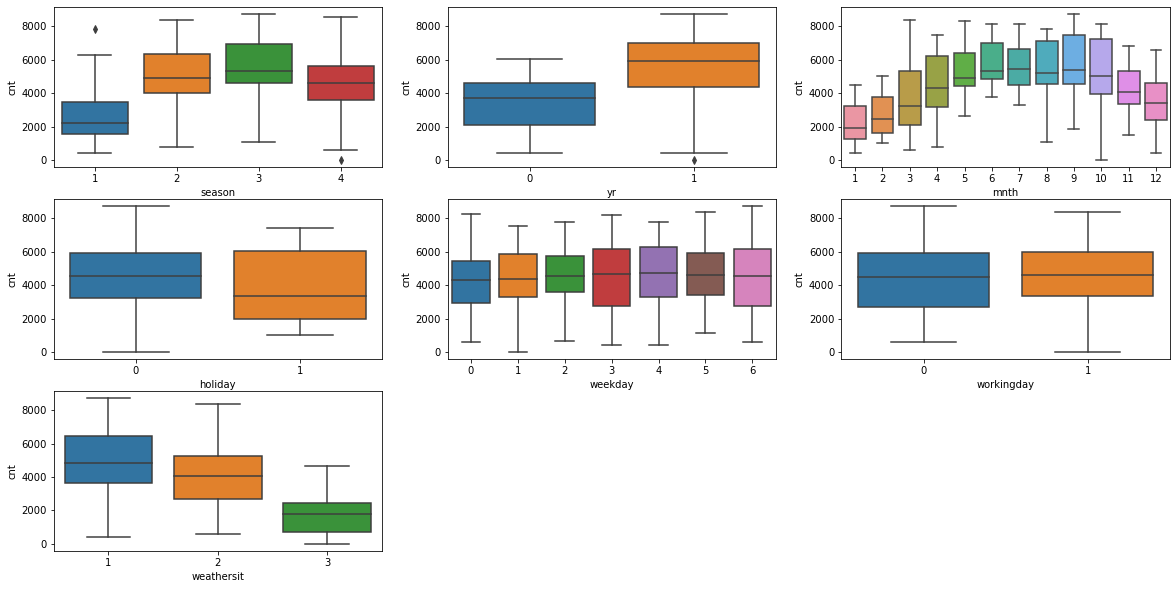

In [10]:
plt.figure(figsize=(20,10))

plt.subplot(3,3,1)
sns.boxplot(x="season",y="cnt",data=df)

plt.subplot(3,3,2)
sns.boxplot(x="yr",y="cnt",data=df)

plt.subplot(3,3,3)
sns.boxplot(x="mnth",y="cnt",data=df)

plt.subplot(3,3,4)
sns.boxplot(x="holiday",y="cnt",data=df)

plt.subplot(3,3,5)
sns.boxplot(x="weekday",y="cnt",data=df)

plt.subplot(3,3,6)
sns.boxplot(x="workingday",y="cnt",data=df)

plt.subplot(3,3,7)
sns.boxplot(x="weathersit",y="cnt",data=df)



- No outliers at this level of categorization visible. Minimum number of users of rental bikes increase in the middle of the year
- Weekday doesnt seem to have impact
- Weather situation have impact. Clear weather more the users
- season seem to have impact
- Weekday seem to have slight impact. Monday, Tuesday and Friday users are more when checked with direct one on one relation

<AxesSubplot:xlabel='yr', ylabel='cnt'>

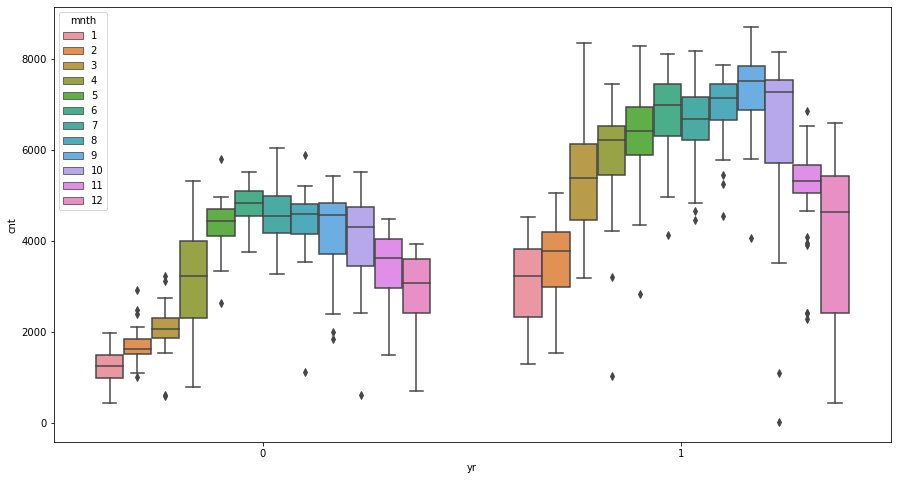

In [11]:
plt.figure(figsize=(15,8))
sns.boxplot(x="yr",y="cnt",data=df,hue="mnth")

Pattern of the higher users mid of the year is same between years. Just the number of users increased in 2019

<AxesSubplot:xlabel='mnth', ylabel='cnt'>

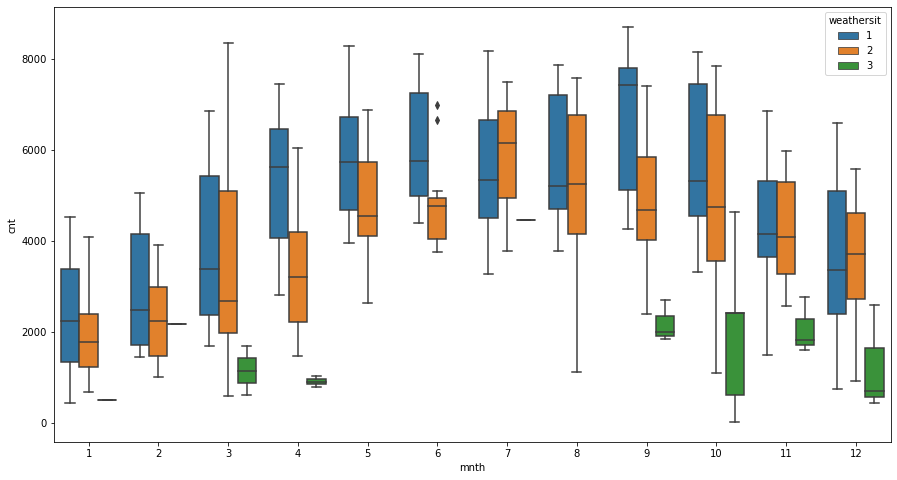

In [12]:
plt.figure(figsize=(15,8))
sns.boxplot(x="mnth",y="cnt",data=df,hue="weathersit")

<AxesSubplot:xlabel='mnth', ylabel='cnt'>

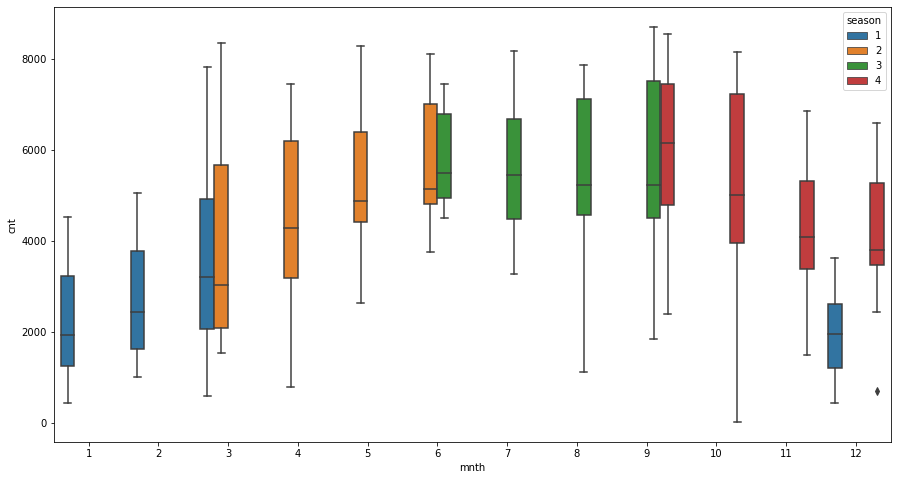

In [13]:
plt.figure(figsize=(15,8))
sns.boxplot(x="mnth",y="cnt",data=df,hue="season")

- Middle of the year has the clear weather indicated by no entries of situation 3 and 4
- Middle of the year season is also summer and fall

Both of them are favorable for biking may be reason for higher count

#### Data Preparation

Creating dummy variables

In [14]:
df["season"] = df["season"].map({1:"spring", 2:"summer", 3:"fall", 4:"winter"})

In [15]:
df["mnth"] = df["mnth"].map({1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr",
                            5:"May", 6:"Jun", 7:"Jul", 8:"Aug",
                            9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"})

In [16]:
df["weekday"] = df["weekday"].map({0:"Tuesday", 1:"Wednesday", 2:"Thursday", 3:"Friday", 4:"Saturday", 5:"Sunday", 6:"Monday"})

In [17]:
df["weathersit"] = df["weathersit"].map({1:"clear", 2:"Misty", 3:"Light_snow", 4:"snow_fog"})

In [18]:
df_cat_sort = pd.get_dummies(data=df,columns=["season","mnth","weekday","weathersit"],drop_first=True)
df_cat_sort.head()

,instant,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Misty,weathersit_clear
0,1,0,0,0,14.110847,18.18125,80.5833,10.749882,331,654,...,0,0,1,0,0,0,0,0,1,0
1,2,0,0,0,14.902598,17.68695,69.6087,16.652113,131,670,...,0,0,0,0,0,0,1,0,1,0
2,3,0,0,1,8.050924,9.47025,43.7273,16.636703,120,1229,...,0,0,0,0,0,0,0,1,0,1
3,4,0,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,...,0,0,0,0,0,1,0,0,0,1
4,5,0,0,1,9.305237,11.46350,43.6957,12.522300,82,1518,...,0,0,0,0,0,0,0,0,0,1


Drop the unnecessary columns

In [19]:
df_cat_sort.drop(labels=["instant","casual","registered"],axis="columns",inplace=True)

In [20]:
df_cat_sort.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Misty,weathersit_clear
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,0,0,0,0,1,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,0,0,0,0,0,1,0,1
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,1,0,0,0,1
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
df_train,df_test = train_test_split(df_cat_sort, test_size=0.3, random_state=100)

In [22]:
df_train.shape

(511, 30)

In [23]:
df_test.shape

(219, 30)

In [24]:
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Misty,weathersit_clear
653,1,0,1,19.201653,23.0423,55.8333,12.208807,7534,0,0,...,1,0,0,0,0,1,0,0,0,1
576,1,0,1,29.246653,33.1448,70.4167,11.083475,7216,0,0,...,0,0,0,0,0,1,0,0,0,1
426,1,0,0,16.980847,20.6746,62.1250,10.792293,4066,1,0,...,0,0,1,0,0,0,0,0,1,0
728,1,0,0,10.489153,11.5850,48.3333,23.500518,1796,1,0,...,0,0,0,0,0,0,1,0,0,1
482,1,0,0,15.443347,18.8752,48.9583,8.708325,4220,0,1,...,0,0,1,0,0,0,0,0,1,0


Feature scaling

MinMax scaling is used

In [25]:
scaler = MinMaxScaler()

In [26]:
numeric_vars = ["temp","atemp","hum","windspeed","cnt"]
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])

In [27]:
# Sanity check to know if the min and max are scalled for numeric variables
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Misty,weathersit_clear
count,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,...,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,0.508806,0.025440,0.677104,0.537386,0.513133,0.650333,0.320844,0.514186,0.242661,0.246575,...,0.086106,0.080235,0.154599,0.133072,0.127202,0.133072,0.142857,0.150685,0.344423,0.626223
std,0.500412,0.157613,0.468042,0.225640,0.212202,0.145741,0.169639,0.224737,0.429112,0.431440,...,0.280795,0.271923,0.361876,0.339986,0.333525,0.339986,0.350270,0.358092,0.475645,0.484280
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.341151,0.332910,0.538858,0.199179,0.356765,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542077,0.529300,0.653499,0.298098,0.519673,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754401,0.414438,0.688737,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
# Creating copy of the data frame for use at manual and RFE bassed approach
import copy
df_train_cpy = copy.deepcopy(df_train)
df_test_cpy = copy.deepcopy(df_test)
df_tain_rfe = copy.deepcopy(df_train)
df_test_rfe = copy.deepcopy(df_test)

#### Feature selection

Multi-colinearity check with pair wise correlation

<AxesSubplot:>

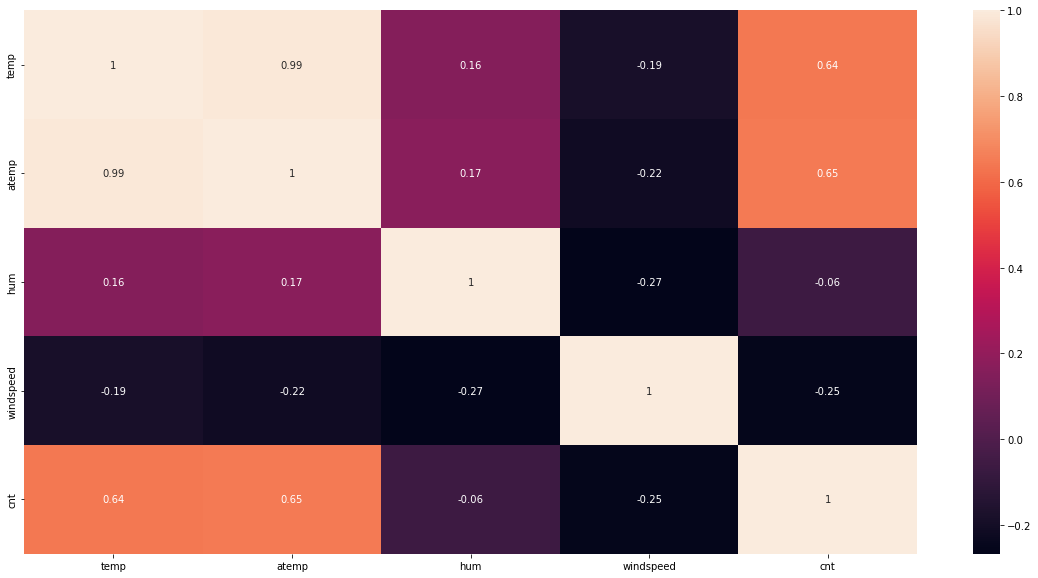

In [29]:
plt.figure(figsize=(20,10))
sns.heatmap(df_train[numeric_vars].corr(),annot=True)

- Checking the correlation between numberic underived variables make sense as the other derived variables from categorical levels will be correlated. Hence only number variables considered
- atemp and temp are highly cor-related as expected. One of them can be dropped. I decide to drop temp as atemp felt temperature seems more relvant for the user to choose a bike ride or closed vehicle drive

In [30]:

df_train.drop(labels=["temp"],inplace=True,axis="columns")

### Feature elimination

#### Backward manual approach

In [31]:
y_train = df_train.pop("cnt")
X_train = df_train

In [32]:
X_train.head()

,yr,holiday,workingday,atemp,hum,windspeed,season_spring,season_summer,season_winter,mnth_Aug,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Misty,weathersit_clear
653,1,0,1,0.501133,0.575354,0.300794,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
576,1,0,1,0.766351,0.725633,0.264686,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
426,1,0,0,0.438975,0.640189,0.255342,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
728,1,0,0,0.200348,0.498067,0.663106,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
482,1,0,0,0.391735,0.504508,0.188475,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


Since we have only few direct variables and a lot of derived variables, checking for feature elimination directly is not making sense unless I understand the association each predictor has on the target variable. Therefore I will build the model directly first using stats model and then perform feature selection like in backward manual feature elimination method

In [33]:
X_train_lm = sm.add_constant(X_train)

lr = sm.OLS(y_train, X_train_lm).fit()

In [34]:
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     101.8
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          2.73e-180
Time:                        23:19:57   Log-Likelihood:                 523.99
No. Observations:                 511   AIC:                            -992.0
Df Residuals:                     483   BIC:                            -873.4
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0536      0.04

In [35]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,holiday,inf
3,workingday,inf
25,weekday_Tuesday,inf
21,weekday_Monday,inf
7,season_spring,10.70
28,weathersit_clear,10.66
9,season_winter,9.47
27,weathersit_Misty,9.23
8,season_summer,8.20
18,mnth_Nov,6.77


Approach: 
- Higher p-values are droped while carefully observing the VIF score for multi co-linearity pattern within the remaining variables
- Adjusted R2 values are observed to compare the model between elimination activities to see if the data explnation capability of the model is reduced


In [36]:
train_drop_labels = ["mnth_Mar"]
X_train_lm.drop(labels=["mnth_Mar"],axis= "columns",inplace=True)

In [37]:
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     106.0
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          2.63e-181
Time:                        23:19:57   Log-Likelihood:                 523.99
No. Observations:                 511   AIC:                            -994.0
Df Residuals:                     484   BIC:                            -879.6
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0535      0.04

In [38]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
20,weekday_Monday,inf
2,holiday,inf
3,workingday,inf
24,weekday_Tuesday,inf
27,weathersit_clear,10.66
7,season_spring,9.58
26,weathersit_Misty,9.23
9,season_winter,9.13
8,season_summer,7.91
4,atemp,5.77


In [39]:
train_drop_labels = ["mnth_Mar","weekday_Saturday"]
X_train_lm.drop(labels=["weekday_Saturday"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     110.4
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          2.61e-182
Time:                        23:19:57   Log-Likelihood:                 523.93
No. Observations:                 511   AIC:                            -995.9
Df Residuals:                     485   BIC:                            -885.7
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0523      0.04

In [40]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,holiday,inf
3,workingday,inf
23,weekday_Tuesday,inf
20,weekday_Monday,inf
26,weathersit_clear,10.66
7,season_spring,9.57
25,weathersit_Misty,9.22
9,season_winter,9.12
8,season_summer,7.90
4,atemp,5.77


In [41]:
train_drop_labels = ["mnth_Mar","weekday_Saturday","weekday_Tuesday"]
X_train_lm.drop(labels=["weekday_Tuesday"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     110.4
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          2.61e-182
Time:                        23:19:58   Log-Likelihood:                 523.93
No. Observations:                 511   AIC:                            -995.9
Df Residuals:                     485   BIC:                            -885.7
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0474      0.05

In [42]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,174.66
25,weathersit_clear,10.66
7,season_spring,9.57
24,weathersit_Misty,9.22
9,season_winter,9.12
8,season_summer,7.90
4,atemp,5.77
10,mnth_Aug,5.42
14,mnth_Jul,4.89
17,mnth_Nov,4.85


In [43]:
train_drop_labels = ["mnth_Mar","weekday_Saturday","weekday_Tuesday","mnth_Oct"]
X_train_lm.drop(labels=["mnth_Oct"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     115.2
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          2.56e-183
Time:                        23:19:58   Log-Likelihood:                 523.86
No. Observations:                 511   AIC:                            -997.7
Df Residuals:                     486   BIC:                            -891.8
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0506      0.05

In [44]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,169.45
24,weathersit_clear,10.65
23,weathersit_Misty,9.21
7,season_spring,9.16
9,season_winter,7.12
8,season_summer,6.73
4,atemp,5.75
10,mnth_Aug,4.59
14,mnth_Jul,4.21
18,mnth_Sep,2.90


In [45]:
train_drop_labels = ["mnth_Mar","weekday_Saturday","weekday_Tuesday","mnth_Oct","mnth_Jul"]
X_train_lm.drop(labels=["mnth_Jul"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     120.4
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          2.76e-184
Time:                        23:19:58   Log-Likelihood:                 523.67
No. Observations:                 511   AIC:                            -999.3
Df Residuals:                     487   BIC:                            -897.7
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0431      0.05

In [46]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,159.55
23,weathersit_clear,10.65
22,weathersit_Misty,9.21
7,season_spring,6.07
4,atemp,4.87
9,season_winter,4.11
8,season_summer,4.07
13,mnth_Jan,2.39
3,workingday,2.34
5,hum,2.00


In [47]:
train_drop_labels = ["mnth_Mar","weekday_Saturday","weekday_Tuesday","mnth_Oct","mnth_Jul","weekday_Thursday"]
X_train_lm.drop(labels=["weekday_Thursday"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     125.9
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          3.19e-185
Time:                        23:19:58   Log-Likelihood:                 523.38
No. Observations:                 511   AIC:                            -1001.
Df Residuals:                     488   BIC:                            -903.3
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0448      0.05

In [48]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,159.20
22,weathersit_clear,10.59
21,weathersit_Misty,9.15
7,season_spring,6.06
4,atemp,4.87
9,season_winter,4.11
8,season_summer,4.07
13,mnth_Jan,2.39
3,workingday,2.08
5,hum,2.00


In [49]:
train_drop_labels = ["mnth_Mar","weekday_Saturday","weekday_Tuesday","mnth_Oct","mnth_Jul","weekday_Thursday",
                    "weekday_Sunday"]
X_train_lm.drop(labels=["weekday_Sunday"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     131.9
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          4.72e-186
Time:                        23:19:58   Log-Likelihood:                 522.81
No. Observations:                 511   AIC:                            -1002.
Df Residuals:                     489   BIC:                            -908.4
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0458      0.05

In [50]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,159.15
21,weathersit_clear,10.56
20,weathersit_Misty,9.08
7,season_spring,6.05
4,atemp,4.87
9,season_winter,4.11
8,season_summer,4.06
13,mnth_Jan,2.39
5,hum,2.00
3,workingday,1.96


In [51]:
train_drop_labels = ["mnth_Mar","weekday_Saturday","weekday_Tuesday","mnth_Oct","mnth_Jul","weekday_Thursday",
                    "weekday_Sunday","holiday"]
X_train_lm.drop(labels=["holiday"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     138.4
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          6.42e-187
Time:                        23:19:58   Log-Likelihood:                 522.30
No. Observations:                 511   AIC:                            -1003.
Df Residuals:                     490   BIC:                            -913.6
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0429      0.05

In [52]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,158.60
20,weathersit_clear,10.56
19,weathersit_Misty,9.08
6,season_spring,6.05
3,atemp,4.86
8,season_winter,4.11
7,season_summer,4.05
12,mnth_Jan,2.39
4,hum,2.00
11,mnth_Feb,1.87


In [53]:
train_drop_labels = ["mnth_Mar","weekday_Saturday","weekday_Tuesday","mnth_Oct","mnth_Jul","weekday_Thursday",
                    "weekday_Sunday","holiday","mnth_Jun"]
X_train_lm.drop(labels=["mnth_Jun"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     144.9
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          2.49e-187
Time:                        23:19:58   Log-Likelihood:                 520.67
No. Observations:                 511   AIC:                            -1001.
Df Residuals:                     491   BIC:                            -916.6
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0368      0.05

In [54]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,157.82
19,weathersit_clear,10.56
18,weathersit_Misty,9.08
6,season_spring,6.04
3,atemp,4.32
8,season_winter,4.11
7,season_summer,3.80
12,mnth_Jan,2.35
4,hum,1.98
11,mnth_Feb,1.85


In [55]:
train_drop_labels = ["mnth_Mar","weekday_Saturday","weekday_Tuesday","mnth_Oct","mnth_Jul","weekday_Thursday",
                    "weekday_Sunday","holiday","mnth_Jun","mnth_May"]
X_train_lm.drop(labels=["mnth_May"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     152.3
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          7.22e-188
Time:                        23:19:58   Log-Likelihood:                 519.32
No. Observations:                 511   AIC:                            -1001.
Df Residuals:                     492   BIC:                            -920.1
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0227      0.04

In [56]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,152.95
18,weathersit_clear,10.53
17,weathersit_Misty,9.06
6,season_spring,5.97
3,atemp,4.21
8,season_winter,4.09
7,season_summer,3.18
12,mnth_Jan,2.35
4,hum,1.95
11,mnth_Feb,1.85


In [57]:
train_drop_labels = ["mnth_Mar","weekday_Saturday","weekday_Tuesday","mnth_Oct","mnth_Jul","weekday_Thursday",
                    "weekday_Sunday","holiday","mnth_Jun","mnth_May","season_spring"]
X_train_lm.drop(labels=["season_spring"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     160.4
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          2.68e-188
Time:                        23:19:58   Log-Likelihood:                 517.69
No. Observations:                 511   AIC:                            -999.4
Df Residuals:                     493   BIC:                            -923.1
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0064      0.04

In [58]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,135.79
17,weathersit_clear,10.42
16,weathersit_Misty,9.00
3,atemp,2.84
7,season_winter,2.35
11,mnth_Jan,2.25
4,hum,1.92
6,season_summer,1.83
12,mnth_Nov,1.74
10,mnth_Feb,1.72


In [59]:
train_drop_labels = ["mnth_Mar","weekday_Saturday","weekday_Tuesday","mnth_Oct","mnth_Jul","weekday_Thursday",
                    "weekday_Sunday","holiday","mnth_Jun","mnth_May","season_spring","weekday_Wednesday"]
X_train_lm.drop(labels=["weekday_Wednesday"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     169.4
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          1.01e-188
Time:                        23:19:58   Log-Likelihood:                 516.01
No. Observations:                 511   AIC:                            -998.0
Df Residuals:                     494   BIC:                            -926.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0061      0.046  

In [60]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,135.79
16,weathersit_clear,10.42
15,weathersit_Misty,9.00
3,atemp,2.84
7,season_winter,2.35
11,mnth_Jan,2.25
4,hum,1.91
6,season_summer,1.83
12,mnth_Nov,1.74
10,mnth_Feb,1.72


Since all the P-values of the remaining predictors are within the significance value 0.05 (assumed as default). Feature can now be eliminated based on VIF only

weather situation clear and misty can be explained by the month of the year typically. Therefore having high VIF value

#### Temporary check 
As the Adjusted R2 got reduced by good amount of score after deleting clear weather situation

In [61]:
df_test_cpy[numeric_vars] = scaler.transform(df_test_cpy[numeric_vars])

In [62]:
y_test_cpy = df_test_cpy.pop("cnt")
X_test_cpy = df_test_cpy


In [63]:
X_test_cpy_lm = sm.add_constant(X_test_cpy)

In [64]:
X_test_cpy_lm.drop(labels="temp",inplace=True,axis="columns")

In [65]:
X_test_cpy_lm.drop(labels=train_drop_labels,inplace=True,axis = "columns")

In [66]:
y_test_cpy_pred = lr.predict(X_test_cpy_lm)

In [67]:
r2_score_checkpoint = r2_score(y_test_cpy, y_test_cpy_pred)

latching the model for prediction and references

In [68]:
lr_good_pred = copy.deepcopy(lr)

Continuation of feature elimination

In [69]:
train_drop_labels = ["mnth_Mar","weekday_Saturday","weekday_Tuesday","mnth_Oct","mnth_Jul","weekday_Thursday",
                    "weekday_Sunday","holiday","mnth_Jun","mnth_May","season_spring","weekday_Wednesday",
                    "weathersit_clear"]
X_train_lm.drop(labels=["weathersit_clear"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     148.4
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          3.59e-172
Time:                        23:19:59   Log-Likelihood:                 473.75
No. Observations:                 511   AIC:                            -915.5
Df Residuals:                     495   BIC:                            -847.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3065      0.035  

In [70]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,65.88
3,atemp,2.77
7,season_winter,2.35
11,mnth_Jan,2.23
6,season_summer,1.82
12,mnth_Nov,1.73
10,mnth_Feb,1.71
2,workingday,1.65
14,weekday_Monday,1.65
4,hum,1.61


In [71]:
train_drop_labels = ["mnth_Mar","weekday_Saturday","weekday_Tuesday","mnth_Oct","mnth_Jul","weekday_Thursday",
                    "weekday_Sunday","holiday","mnth_Jun","mnth_May","season_spring","weekday_Wednesday",
                    "weathersit_clear", "mnth_Dec"]
X_train_lm.drop(labels=["mnth_Dec"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     158.3
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          1.11e-172
Time:                        23:19:59   Log-Likelihood:                 472.31
No. Observations:                 511   AIC:                            -914.6
Df Residuals:                     496   BIC:                            -851.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2887      0.033  

In [72]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,59.72
3,atemp,2.31
7,season_winter,2.30
10,mnth_Jan,1.93
6,season_summer,1.71
2,workingday,1.65
13,weekday_Monday,1.65
4,hum,1.60
9,mnth_Feb,1.54
8,mnth_Aug,1.44


In [73]:
train_drop_labels = ["mnth_Mar","weekday_Saturday","weekday_Tuesday","mnth_Oct","mnth_Jul","weekday_Thursday",
                    "weekday_Sunday","holiday","mnth_Jun","mnth_May","season_spring","weekday_Wednesday",
                    "weathersit_clear", "mnth_Dec", "mnth_Nov"]
X_train_lm.drop(labels=["mnth_Nov"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     170.2
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          1.67e-173
Time:                        23:19:59   Log-Likelihood:                 471.59
No. Observations:                 511   AIC:                            -915.2
Df Residuals:                     497   BIC:                            -855.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2844      0.033  

In [74]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,59.01
3,atemp,2.29
7,season_winter,1.96
10,mnth_Jan,1.92
6,season_summer,1.70
2,workingday,1.65
12,weekday_Monday,1.64
4,hum,1.59
9,mnth_Feb,1.54
8,mnth_Aug,1.44


In [75]:
train_drop_labels = ["mnth_Mar","weekday_Saturday","weekday_Tuesday","mnth_Oct","mnth_Jul","weekday_Thursday",
                    "weekday_Sunday","holiday","mnth_Jun","mnth_May","season_spring","weekday_Wednesday",
                    "weathersit_clear", "mnth_Dec", "mnth_Nov", "mnth_Feb"]
X_train_lm.drop(labels=["mnth_Feb"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     184.2
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          2.35e-174
Time:                        23:19:59   Log-Likelihood:                 470.91
No. Observations:                 511   AIC:                            -915.8
Df Residuals:                     498   BIC:                            -860.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2710      0.031  

In [76]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,51.85
3,atemp,1.88
2,workingday,1.64
11,weekday_Monday,1.64
4,hum,1.59
7,season_winter,1.56
9,mnth_Jan,1.54
6,season_summer,1.48
8,mnth_Aug,1.42
12,weathersit_Misty,1.40


In [77]:
train_drop_labels = ["mnth_Mar","weekday_Saturday","weekday_Tuesday","mnth_Oct","mnth_Jul","weekday_Thursday",
                    "weekday_Sunday","holiday","mnth_Jun","mnth_May","season_spring","weekday_Wednesday",
                    "weathersit_clear", "mnth_Dec", "mnth_Nov", "mnth_Feb", "mnth_Jan"]
X_train_lm.drop(labels=["mnth_Jan"],axis= "columns",inplace=True)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     199.9
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          6.75e-175
Time:                        23:19:59   Log-Likelihood:                 469.44
No. Observations:                 511   AIC:                            -914.9
Df Residuals:                     499   BIC:                            -864.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2546      0.030  

In [78]:
vif = pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,46.81
2,workingday,1.64
10,weekday_Monday,1.64
4,hum,1.59
3,atemp,1.50
8,mnth_Aug,1.41
11,weathersit_Misty,1.40
6,season_summer,1.38
7,season_winter,1.31
9,mnth_Sep,1.20


Residual analysis for the training data

In [79]:
y_train_pred = lr.predict(X_train_lm)

Text(0.5, 0, 'Errors')

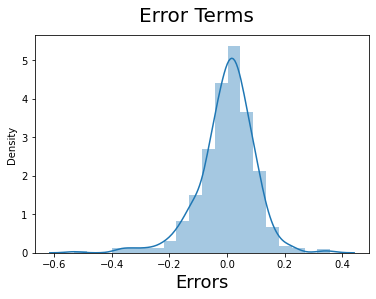

In [80]:
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

Error terms are very close to normal distribution satisfying the assumption of linear equation that errors are normally distributed or in other terms there is not a significant variance difference of y at different point of x in the given data set

<AxesSubplot:xlabel='cnt'>

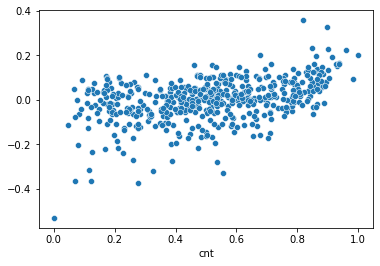

In [81]:
fig = plt.figure()
sns.scatterplot(x=y_train,y=(y_train - y_train_pred))

No pattern can be observed to prove the assumption of error term independency

In [82]:
train_drop_labels

['mnth_Mar',
 'weekday_Saturday',
 'weekday_Tuesday',
 'mnth_Oct',
 'mnth_Jul',
 'weekday_Thursday',
 'weekday_Sunday',
 'holiday',
 'mnth_Jun',
 'mnth_May',
 'season_spring',
 'weekday_Wednesday',
 'weathersit_clear',
 'mnth_Dec',
 'mnth_Nov',
 'mnth_Feb',
 'mnth_Jan']

#### Test data prediction

Creation of the test data

In [83]:
df_test[numeric_vars] = scaler.transform(df_test[numeric_vars])

In [84]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Misty,weathersit_clear
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.479452,0.036530,0.698630,0.558941,0.532991,0.638508,0.313350,0.520592,0.255708,0.264840,...,0.082192,0.086758,0.118721,0.164384,0.178082,0.164384,0.146119,0.127854,0.319635,0.652968
std,0.500722,0.188034,0.459904,0.233698,0.217888,0.148974,0.159947,0.218435,0.437258,0.442259,...,0.275286,0.282125,0.324202,0.371472,0.383458,0.371472,0.354034,0.334692,0.467403,0.477117
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.354650,0.344751,0.527265,0.198517,0.377531,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558691,0.549198,0.627737,0.299459,0.524275,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.000000,0.759096,0.714132,0.743928,0.403048,0.672745,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [85]:
y_test = df_test.pop("cnt")
X_test = df_test

In [86]:
X_test_lm = sm.add_constant(X_test)

In [87]:
X_test_lm.drop(labels=train_drop_labels,axis="columns",inplace=True)
X_test_lm.drop(labels="temp",axis="columns",inplace=True)

In [88]:
y_test_pred = lr.predict(X_test_lm)

Model evaluation

Text(0, 0.5, 'y_test_pred')

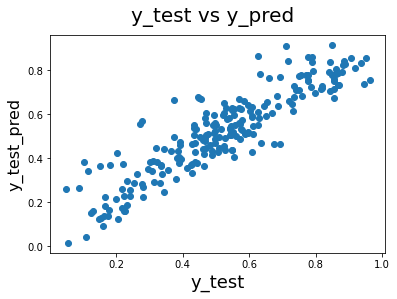

In [89]:
fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_test_pred', fontsize = 16)      

In [90]:
r2_score(y_test, y_test_pred)

0.8081229689151234

#### Conclusion on preferred model based on manual approach
Based on the theoritical understanding, last fit model "lm" generalize the data behavior between test and train

Model --> lr

- R2 score of train = 0.815
- Adjusted R2score of train = 0.811
- R2 score of test = 0.808

Model  --> lr_good_pred

At the check point before deleting the clear weather situation predictor, 
- R2 score of train = 0.841
- R2 score of test = 0.821



##### lr_good_pred is a good model for prediction as R2 score is high but the VIF for couple of variables are high indicating multicolinearilty. Therefore not good for inferences

##### lr is good model for inferences compared to lr_good_pred and the final equation for the inference based on manual feature elimination is below

##### cnt = 0.2546 + yr(0.2312) + workingday(0.0439) + atemp(0.5839) - hum(0.3010) - windspeed(0.2085) + summer(0.1035) + winter(0.1400) + august(0.0692) + september(0.12) + monday(0.0503) - misty(0.0264)

#### Automatic feature elimination using RFE

In [91]:
y_train_rfe = df_tain_rfe.pop("cnt")
X_train_rfe = df_tain_rfe

In [92]:
lm_sklearn =LinearRegression()
lm_sklearn.fit(X_train_rfe,y_train_rfe)

LinearRegression()

In [93]:
rfe = RFE(lm_sklearn,n_features_to_select=10)
rfe_op = rfe.fit(X_train_rfe,y_train_rfe)

In [94]:

list(zip(X_train_rfe.columns,rfe_op.support_,rfe_op.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 5),
 ('temp', True, 1),
 ('atemp', False, 10),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 3),
 ('season_winter', False, 2),
 ('mnth_Aug', False, 12),
 ('mnth_Dec', False, 8),
 ('mnth_Feb', False, 9),
 ('mnth_Jan', False, 6),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 18),
 ('mnth_Mar', False, 20),
 ('mnth_May', False, 11),
 ('mnth_Nov', False, 7),
 ('mnth_Oct', False, 16),
 ('mnth_Sep', True, 1),
 ('weekday_Monday', False, 4),
 ('weekday_Saturday', False, 19),
 ('weekday_Sunday', False, 17),
 ('weekday_Thursday', False, 15),
 ('weekday_Tuesday', False, 13),
 ('weekday_Wednesday', False, 14),
 ('weathersit_Misty', True, 1),
 ('weathersit_clear', True, 1)]

In [95]:
rfe_labels_drop = X_train_rfe.columns[~rfe_op.support_]

In [96]:
X_train_rfe.drop(labels=X_train_rfe.columns[~rfe_op.support_],axis="columns",inplace=True)

In [97]:
X_train_rfe_lm = sm.add_constant(X_train_rfe)
lr_rfe = sm.OLS(y_train_rfe, X_train_rfe_lm).fit()
print(lr_rfe.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     246.6
Date:                Tue, 13 Sep 2022   Prob (F-statistic):          4.12e-186
Time:                        23:20:01   Log-Likelihood:                 493.12
No. Observations:                 511   AIC:                            -964.2
Df Residuals:                     500   BIC:                            -917.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1451      0.045  

Residual error analysis

In [98]:
y_train_rfe_pred = lr_rfe.predict(X_train_rfe_lm)

Text(0.5, 0, 'Errors')

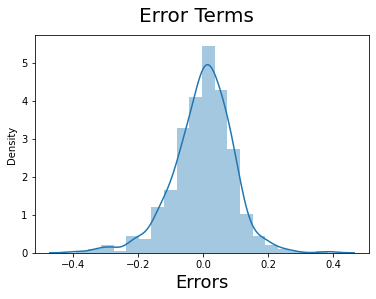

In [99]:
fig = plt.figure()
sns.distplot((y_train_rfe - y_train_rfe_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)  

Error terms are very close to normal distribution satisfying the assumption of linear equation that errors are normally distributed or in other terms there is not a significant variance difference of y at different point of x in the given data set

<AxesSubplot:xlabel='cnt'>

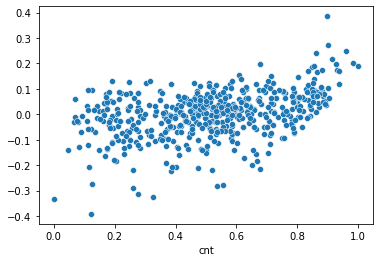

In [100]:
fig = plt.figure()
sns.scatterplot(x=y_train_rfe,y=(y_train_rfe - y_train_rfe_pred))

No pattern can be observed to prove the assumption of error term independency

Model evaluation

In [101]:
#df_test_rfe.drop(labels="temp",axis="columns",inplace=True)
df_test_rfe[numeric_vars] = scaler.transform(df_test_rfe[numeric_vars])
y_test_rfe = df_test_rfe.pop('cnt')
X_test_rfe = df_test_rfe


In [102]:
X_test_rfe.drop(labels=rfe_labels_drop,axis="columns",inplace=True)

In [103]:
X_test_rfe_lm = sm.add_constant(X_test_rfe)
y_test_rfe_pred = lr_rfe.predict(X_test_rfe_lm)
X_test_rfe_lm.head()

,const,yr,holiday,temp,hum,windspeed,season_spring,mnth_Jul,mnth_Sep,weathersit_Misty,weathersit_clear
184,1.0,0,1,0.831783,0.657364,0.084219,0,1,0,1,0
535,1.0,1,0,0.901354,0.610133,0.153728,0,0,0,0,1
299,1.0,0,0,0.511964,0.837699,0.334206,0,0,0,1,0
221,1.0,0,0,0.881625,0.437098,0.339570,0,0,0,0,1
152,1.0,0,0,0.817246,0.314298,0.537414,0,0,0,0,1


Text(0, 0.5, 'y_test_rfe_pred')

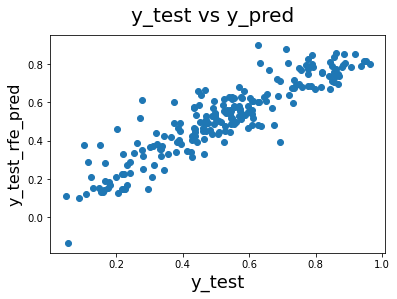

In [104]:
fig = plt.figure()
plt.scatter(y_test_rfe, y_test_rfe_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_test_rfe_pred', fontsize = 16)  

In [105]:
r2_score(y_test_rfe, y_test_rfe_pred)

0.8124105584998036

In [106]:
X_test_rfe.shape

(219, 10)

##### Resulting equation from RFE and linear modelling is as below:
##### cnt = 0.1451 + yr(0.2330) - holiday(0.0910) + temp(0.4042) -hum(0.1287) -windspeed(0.1776) - spring(0.1483) - july(0.0802) + september(0.0584) + misty(0.1811) + clear(0.2418)

Note: I prefer equation resulting from RFE just because there is no weekday term compared to manual backward feature elimination that has only Monday term. Statistically both the models are providing a good prediction of test data

## Model interpretation/inference

Common inference from manual and RFE based feature elimination approach
- Year has a possitive impact on the number of bike users. This means that business can generally increase the number of bikes offered to customers provided all the other parameters are similar as the data in the gived data set
- Working day has +ve impact conversly holiday has negative impact [Inline with data visualization]
- Temperature/felt temperature have positive impact. Warm days attract more people to use bikes than cooler days
- humidity have negative impact
- windspeed have negarive impact
- summer and winter have positive impact or conversly spring have negative impact [Inline with data visualization]
- More bikes are used in the month of august and september compared to other months
- Clear weather has positive impact [Inline with data visualization]

Inference contadicting between manual and RFE based feature elimination approach
- Misty has positive impact in RFE where as negatively impacted in manual approach
    - By looking at the below count plot, the difference in equation seems to be because of minor degree of collinearity
        - Misty weather days are considerable in august month, august is taken into possitive consideration in manual approach where as not in the RFE

<AxesSubplot:xlabel='mnth', ylabel='count'>

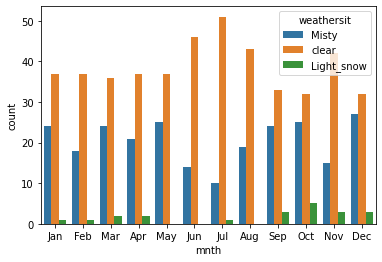

In [107]:
plt.figure()
sns.countplot(data=df,x='mnth',hue='weathersit')